In [1]:
# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

# For the first-time user, you should download these two pre-trained tokenizer
#nltk.download('punkt') 
#nltk.download('stopwords')

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LdaModel
from gensim.models import LsiModel

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


def topicconvert(num_topics,corpus,label,colmns):
    X = []    
    for i in range (0,len(corpus)):
        top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(num_topics)]
        X.append(topic_vec)
    X_df = pd.DataFrame(X, index =label,columns =colmns)
    return X_df
    

def stdscaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scX_df = scaler.transform(df)
    df=pd.DataFrame(scX_df, index =df.index,columns =df.columns  )
    return df

In [2]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',index_col = 0)
sentiment_label = df["Recommended IND"]
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# Pre-process
# choose review text
pdtextpreprocess = df[["Title","Review Text", "Rating"]].copy()
pdtextpreprocess['index'] = pdtextpreprocess.index

documents = [str(m)+" "+str(n) for m,n in zip(pdtextpreprocess["Title"],pdtextpreprocess["Review Text"])] # add title as part of review text

In [16]:
print(len(documents),documents[0])

23486 nan Absolutely wonderful - silky and sexy and comfortable


In [4]:
texts_tokenized = [[word.lower() for word in word_tokenize(str(document))] for document in documents]#text tokenized and transformed to lowercase

stop_words = set(stopwords.words('english'))
texts_filtered_stopwords = [[word for word in document if not word in stop_words] for document in texts_tokenized]#move stop_words

# puncuations
english_punctuations = list(string.punctuation)
texts_filtered = [[word for word in document if not word in english_punctuations] for document in texts_filtered_stopwords]#move english_punctuations

stemmer = PorterStemmer()
#stemmer =LancasterStemmer()
texts_stemmed = [[stemmer.stem(word) for word in docment] for docment in texts_filtered]

all_stems = sum(texts_stemmed, [])
stems_once = set(stem for stem in set(all_stems) if all_stems.count(stem) == 1)
texts = [[stem for stem in text if stem not in stems_once] for text in texts_stemmed]

In [48]:
print(len(texts_tokenized),texts_tokenized[0])
#print(stop_words)
print(len(texts_filtered_stopwords),texts_filtered_stopwords[0])
print(len(texts_filtered),texts_filtered[0])

#print(english_punctuations)
print(len(texts_stemmed),texts_stemmed[0])
#print(all_stems)
print(len(texts),texts[1])


23486 ['nan', 'absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable']
23486 ['nan', 'absolutely', 'wonderful', '-', 'silky', 'sexy', 'comfortable']
23486 ['nan', 'absolutely', 'wonderful', 'silky', 'sexy', 'comfortable']
23486 ['nan', 'absolut', 'wonder', 'silki', 'sexi', 'comfort']
23486 ['nan', 'love', 'dress', "'s", 'sooo', 'pretti', 'happen', 'find', 'store', "'m", 'glad', 'bc', 'never', 'would', 'order', 'onlin', 'bc', "'s", 'petit', 'bought', 'petit', '5', '8', "''", 'love', 'length', 'me-', 'hit', 'littl', 'knee', 'would', 'definit', 'true', 'midi', 'someon', 'truli', 'petit']


In [5]:
from gensim.corpora import Dictionary

dictionary = Dictionary(texts)  # fit dictionary

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(line) for line in texts]  # convert corpus to BoW format

tfidf = models.TfidfModel(corpus)#calculate tf-idf
corpus_tfidf = tfidf[corpus]#use tf-idfs to represent documents

## Build the LSA and LDA topic models for the reviews. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LdaModel
from gensim.models import LsiModel

In [64]:

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [65]:
model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.328*"sweater" + 0.068*"wash" + 0.053*"knit" + 0.040*"dri" + 0.032*"cozi" + 0.023*"bulki" + 0.022*"clean" + 0.020*"purpl" + 0.018*"sleev" + 0.017*"cold"'),
 (1,
  '0.049*"n\'t" + 0.025*"tri" + 0.025*"one" + 0.024*"..." + 0.019*"\'s" + 0.016*"store" + 0.014*"would" + 0.013*"retail" + 0.013*"onlin" + 0.013*"could"'),
 (2,
  '0.066*"piec" + 0.062*"jacket" + 0.029*"layer" + 0.029*"warm" + 0.026*"coat" + 0.024*"cardigan" + 0.020*"winter" + 0.019*"fall" + 0.018*"weather" + 0.016*"vest"'),
 (3,
  '0.105*"top" + 0.033*"shirt" + 0.027*"pretti" + 0.026*"\'s" + 0.026*"color" + 0.022*"detail" + 0.020*"sleev" + 0.020*"white" + 0.017*"back" + 0.015*"blous"'),
 (4,
  '0.101*"size" + 0.047*"fit" + 0.047*"small" + 0.041*"order" + 0.032*"run" + 0.029*"larg" + 0.027*"usual" + 0.021*"medium" + 0.020*"\'m" + 0.019*"big"'),
 (5,
  '0.071*"look" + 0.062*"like" + 0.038*"fabric" + 0.026*"realli" + 0.023*"materi" + 0.019*"would" + 0.018*"nice" + 0.017*"n\'t" + 0.017*"cut" + 0.017*"made"'),
 (6,
  '0.23

In [8]:
num_topics = 10
chunksize = 2000
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LsiModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    chunksize=chunksize,
    num_topics=num_topics,
)

In [9]:
model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.745*"nan" + 0.142*"dress" + 0.110*"top" + 0.102*"love" + 0.099*"size" + 0.096*"great" + 0.092*"fit" + 0.086*"look" + 0.086*"\'s" + 0.082*"color"'),
 (1,
  '-0.666*"nan" + 0.156*"dress" + 0.122*"top" + 0.112*"size" + 0.105*"love" + 0.102*"fit" + 0.101*"great" + 0.096*"\'s" + 0.095*"look" + 0.091*"n\'t"'),
 (2,
  '0.380*"dress" + -0.243*"jean" + -0.239*"great" + -0.226*"shirt" + -0.203*"sweater" + -0.177*"soft" + 0.169*"small" + -0.158*"comfort" + 0.150*"size" + -0.134*"pant"'),
 (3,
  '0.664*"dress" + -0.250*"top" + -0.166*"small" + 0.162*"comfort" + -0.159*"shirt" + 0.158*"perfect" + -0.132*"larg" + 0.130*"great" + -0.126*"run" + 0.103*"compliment"'),
 (4,
  '-0.298*"pant" + -0.233*"jean" + -0.196*"5" + -0.193*"size" + -0.190*"small" + 0.188*"shirt" + 0.170*"dress" + 0.165*"top" + -0.151*"\'\'" + -0.140*"run"'),
 (5,
  '-0.626*"sweater" + 0.409*"top" + 0.241*"cute" + 0.218*"shirt" + 0.118*"dress" + 0.117*"summer" + 0.104*"run" + 0.096*"comfort" + 0.094*"super" + 0.093*"great"

In [14]:
import gensim
lsi=model
V = gensim.matutils.corpus2dense(lsi[corpus_tfidf], len(lsi.projection.s)).T / lsi.projection.s

In [29]:
print(len(V),
len(V[0]),
V[0])

colmns = []
for i in range(0,10):
    colmns.append("vector"+str(i))
X_df = pd.DataFrame(V, index =pdtextpreprocess.index,columns =colmns  )
#X_df["Rating"]=pdtextpreprocess["Rating"].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_df)
scX_df = scaler.transform(X_df)
scX_df =pd.DataFrame(scX_df, index =X_df.index,columns =X_df.columns  )
print(scX_df)

23486 10 [ 6.01587442e-03 -3.34397192e-03 -2.97169157e-03  5.74435099e-03
 -6.63999124e-04  1.97436792e-03  1.27138355e-03  5.93627006e-04
 -3.48694417e-05  8.59183845e-04]
        vector0   vector1   vector2   vector3   vector4   vector5   vector6  \
0      0.200911 -1.262701 -0.392759  0.850526 -0.128484  0.309103  0.183827   
1      0.216809 -0.046255  1.542304  0.199755 -1.140573 -0.539748 -0.643443   
2     -0.400597  0.166036  1.073885 -0.723609 -0.347171  0.319591  0.613375   
3     -0.520306  0.036032 -1.317569  1.350010 -0.403113  0.435925  0.695556   
4     -0.373786  0.157123 -2.317296 -0.253679  0.729799  1.390008 -2.043925   
...         ...       ...       ...       ...       ...       ...       ...   
23481 -0.357744  0.175523 -0.083534  3.011508  0.970864  0.815673  0.439362   
23482 -0.403814  0.160717 -0.348784 -0.665881  1.376738 -0.919036 -1.002359   
23483  0.117207  0.613860  0.351335 -1.026174  0.615844  0.792334 -0.410237   
23484  0.073783  0.573307  1.151163  

## Predict sentiment

(Recommended / Not recommended) of reviews using their bag-of-topics features by fitting a logistic regression model.

In [ ]:
#lda and logistic classfication

In [77]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [28]:
print(len(corpus))

colmns = []
for i in range(0,10):
    colmns.append("vector"+str(i))

X = []

for i in range (0,len(corpus)):
    top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    X.append(topic_vec)
X_df = pd.DataFrame(X, index =pdtextpreprocess.index,columns =colmns  )

23486


AttributeError: 'LsiModel' object has no attribute 'get_document_topics'

In [84]:
print(X_df.shape)
X_df["Rating"]=pdtextpreprocess["Rating"].copy()
print(X_df.shape)

(23486, 10)
(23486, 11)


In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_df)
scX_df = scaler.transform(X_df)
scX_df =pd.DataFrame(scX_df, index =X_df.index,columns =X_df.columns  )
print(scX_df)

        vector0   vector1   vector2   vector3   vector4   vector5   vector6  \
0      1.228397 -0.197151 -0.259391  0.809569  0.156367 -0.604225 -0.499781   
1      0.373461 -0.508374 -0.609801 -0.538411  1.213483 -1.168582 -0.384493   
2     -0.327509 -0.540116 -0.642905 -1.148561 -1.209102  0.605142  2.771458   
3      0.352591 -0.380686 -0.465949  2.668816 -0.499911 -1.398551 -0.395337   
4     -0.563099 -0.390477  1.485862  1.149964 -1.088768  0.441217 -0.888631   
...         ...       ...       ...       ...       ...       ...       ...   
23481  3.585471 -0.369466 -0.453692  1.372616 -0.042231 -1.235552 -0.877557   
23482 -0.690328 -0.463325 -0.554844 -1.151539 -0.703098  3.299086 -1.017399   
23483 -0.618572 -0.418135 -0.508246 -0.673231  2.649557 -0.014528 -0.272771   
23484  2.372972 -0.528973 -0.628208 -0.549060  0.769541  0.097538  0.071013   
23485  0.609641 -0.345357 -0.426235  2.077405 -0.748967 -0.980492 -0.683870   

        vector7   vector8   vector9    Rating  
0  

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
lr=LogisticRegression(tol=0.0001, C=1.0,solver='lbfgs', max_iter=100,)
accu = []
auc = []
t1=time.time()
kf=KFold(n_splits=10)

kf.get_n_splits(scX_df)
for train_index, test_index in kf.split(scX_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = scX_df.iloc[train_index], scX_df.iloc[test_index]
    y_train, y_test = sentiment_label.iloc[train_index], sentiment_label.iloc[test_index]
    lr.fit(X_train,y_train)
    accu.append(lr.score(X_test,y_test))
    auc.append(roc_auc_score(y_test,lr.predict(X_test)))
    print("runtime is ",time.time()-t1)
    
    
    
"""accu = []
auc = []
t1=time.time()
randomseed =[1,2,3,4,5,6,7,8,9,10]

for i in randomseed:
    X_train, X_test, y_train, y_test = train_test_split(scX_df, sentiment_label, test_size=0.2, random_state=i)
    #print("runtime is ",time.time()-t1)
    lr.fit(X_train,y_train)
    #print("runtime is ",time.time()-t1)
    accu.append(lr.score(X_test,y_test))
    #print("runtime is ",time.time()-t1)
    auc.append(roc_auc_score(y_test,lr.predict(X_test)))
    print("runtime is ",time.time()-t1)

    
    """

runtime is  0.0279080867767334
runtime is  0.0544281005859375
runtime is  0.07719111442565918
runtime is  0.10048103332519531
runtime is  0.12475800514221191
runtime is  0.1456451416015625
runtime is  0.16742920875549316
runtime is  0.18632292747497559
runtime is  0.20609521865844727
runtime is  0.22591423988342285


'accu = []\nauc = []\nt1=time.time()\nrandomseed =[1,2,3,4,5,6,7,8,9,10]\n\nfor i in randomseed:\n    X_train, X_test, y_train, y_test = train_test_split(scX_df, sentiment_label, test_size=0.2, random_state=i)\n    #print("runtime is ",time.time()-t1)\n    lr.fit(X_train,y_train)\n    #print("runtime is ",time.time()-t1)\n    accu.append(lr.score(X_test,y_test))\n    #print("runtime is ",time.time()-t1)\n    auc.append(roc_auc_score(y_test,lr.predict(X_test)))\n    print("runtime is ",time.time()-t1)\n\n    \n    '

[0.8501489995742869, 0.8641975308641975, 0.8744146445295871, 0.8535547041294168, 0.859514687100894, 0.8680289484887186, 0.8735093696763203, 0.850511073253833, 0.8620102214650767, 0.8637137989778535] [0.6786645800730309, 0.6910644518942355, 0.7115671870558531, 0.6673024256651017, 0.6990758567577975, 0.7056145360318997, 0.691260095143268, 0.6883669930640555, 0.7048232536444525, 0.693509823444811]


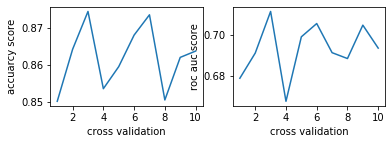

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

print(accu,auc)
ax1 =plt.subplot(221,xlabel ='cross validation',ylabel='accuarcy score' )
ax1.plot(range(1,11), accu)
#ax1.xlabel('cross validation')
#ax2.ylabel('accuarcy score')
ax2 =plt.subplot(222,xlabel ='cross validation',ylabel='roc auc score')
ax2.plot(range(1,11), auc)
#ax2.xlabel('cross validation')
#ax2.ylabel('roc auc score')

## Calculate the prediction error
(Defined as the percentage of incorrect predictions)

### (BONUS. NOT required) 
Implement the cross validation algorithm during your model training to select the topic number in a LSA/LDA model.

In [2]:
"""Now remove 20% document in the dictionary mark as unseen"""
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',index_col = 0)
sentiment_label = df["Recommended IND"]
pdtextpreprocess = df[["Title","Review Text", "Rating"]].copy()
pdtextpreprocess['index'] = pdtextpreprocess.index

documents = [str(m)+" "+str(n) for m,n in zip(pdtextpreprocess["Title"],pdtextpreprocess["Review Text"])] # add title as part of review text
texts_tokenized = [[word.lower() for word in word_tokenize(str(document))] for document in documents]#text tokenized and transformed to lowercase

stop_words = set(stopwords.words('english'))
texts_filtered_stopwords = [[word for word in document if not word in stop_words] for document in texts_tokenized]#move stop_words

# puncuations
english_punctuations = list(string.punctuation)
texts_filtered = [[word for word in document if not word in english_punctuations] for document in texts_filtered_stopwords]#move english_punctuations

stemmer = PorterStemmer()
#stemmer =LancasterStemmer()
texts_stemmed = [[stemmer.stem(word) for word in docment] for docment in texts_filtered]

all_stems = sum(texts_stemmed, [])
stems_once = set(stem for stem in set(all_stems) if all_stems.count(stem) == 1)
texts = [[stem for stem in text if stem not in stems_once] for text in texts_stemmed]

In [39]:
train_texts = texts[:int(0.8*len(texts))].copy()
test_texts =texts[int(0.8*len(texts)):].copy()
train_label =pd.Series(sentiment_label.iloc[:int(0.8*len(texts))].copy())
test_label = pd.Series(sentiment_label.iloc[int(0.8*len(texts)):].copy())

print(len(train_texts),len(test_texts),train_label,test_label)

18788 4698 0        1
1        1
2        0
3        1
4        1
        ..
18783    1
18784    1
18785    1
18786    1
18787    1
Name: Recommended IND, Length: 18788, dtype: int64 18788    0
18789    1
18790    1
18791    1
18792    1
        ..
23481    1
23482    1
23483    0
23484    1
23485    1
Name: Recommended IND, Length: 4698, dtype: int64


In [41]:
from gensim.corpora import Dictionary

dictionary = Dictionary(train_texts)  # fit dictionary

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus_train = [dictionary.doc2bow(line) for line in train_texts]  # convert corpus to BoW format

tfidf = models.TfidfModel(corpus_train)#calculate tf-idf
train_tfidf = tfidf[corpus_train]#use tf-idfs to represent documents


corpus_test = [dictionary.doc2bow(line) for line in test_texts]  # convert corpus to BoW format

tfidf = models.TfidfModel(corpus_test)#calculate tf-idf
test_tfidf = tfidf[corpus_test]#use tf-idfs to represent documents

In [45]:
# Set training parameters.
cvtopics = np.linspace(5,100,20)

chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
result = pd.DataFrame(columns=['CVaccu', 'CVauc', 'unseenaccu','unseenauc'])

t1=time.time()
for num_topics in cvtopics:
# Make a index to word dictionary.
    num_topics= int(num_topics)
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus_train,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    colmns = []
    for i in range(0,(num_topics)):
        colmns.append("vector"+str(i))

    Xtrain_df =topicconvert(num_topics,corpus_train,train_label.index,colmns)
    Xtrain_df["Rating"]=df["Rating"].iloc[:int(0.8*len(texts))].copy()
    Xtrain_df=stdscaler(Xtrain_df)
    
    Xtest_df =topicconvert(num_topics,corpus_test,test_label.index,colmns)
    Xtest_df["Rating"]=df["Rating"].iloc[int(0.8*len(texts)):].copy()
    Xtest_df=stdscaler(Xtest_df)
    
    
    lr=LogisticRegression(tol=0.0001, C=1.0,solver='lbfgs', max_iter=100,)
    accu = []
    auc = []
    
    kf=KFold(n_splits=5)

    kf.get_n_splits(Xtrain_df)
    for train_index, test_index in kf.split(Xtrain_df):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Xtrain_df.iloc[train_index], Xtrain_df.iloc[test_index]
        y_train, y_test = train_label.iloc[train_index], train_label.iloc[test_index]
        lr.fit(X_train,y_train)
        accu.append(lr.score(X_test,y_test))
        auc.append(roc_auc_score(y_test,lr.predict(X_test)))
        
        print("runtime is ",time.time()-t1)
    unseen_accu=lr.score(Xtest_df,test_label)
    unseen_auc=roc_auc_score(test_label,lr.predict(Xtest_df))
    cvresult = pd.DataFrame([[np.average(accu),np.average(auc),unseen_accu,unseen_auc]],columns=['CVaccu', 'CVauc', 'unseenaccu','unseenauc'] )
    
    result =result.append(cvresult)
    

runtime is  117.2385721206665
runtime is  117.25544714927673
runtime is  117.27222418785095
runtime is  117.28883099555969
runtime is  117.3047502040863
runtime is  251.37200212478638
runtime is  251.38833212852478
runtime is  251.40353512763977
runtime is  251.41927409172058
runtime is  251.43526124954224
runtime is  384.3679401874542
runtime is  384.38387417793274
runtime is  384.4002661705017
runtime is  384.41793417930603
runtime is  384.4339950084686
runtime is  501.0147981643677
runtime is  501.0320682525635
runtime is  501.05056715011597
runtime is  501.0684983730316
runtime is  501.085196018219
runtime is  618.5527741909027
runtime is  618.5706632137299
runtime is  618.5884160995483
runtime is  618.6053330898285
runtime is  618.6225111484528
runtime is  728.5433962345123
runtime is  728.56289935112
runtime is  728.5808193683624
runtime is  728.5997562408447
runtime is  728.618821144104
runtime is  840.6084401607513
runtime is  840.6279711723328
runtime is  840.648359298706
runt

the optimal topics is 15.0


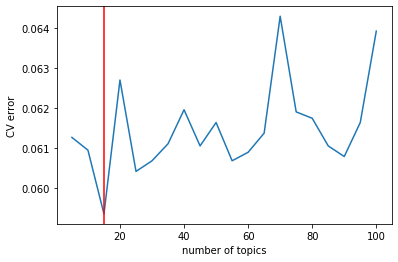

,CVaccu,CVauc,unseenaccu,unseenauc,topics,CVerror,unseenerror
0,0.938737,0.902082,0.940826,0.901485,5.0,0.061263,0.059174
1,0.939057,0.899673,0.938484,0.894930,10.0,0.060943,0.061516
2,0.940653,0.898248,0.941464,0.893946,15.0,0.059347,0.058536
3,0.937300,0.900792,0.942103,0.904595,20.0,0.062700,0.057897
4,0.939589,0.897668,0.939336,0.889385,25.0,0.060411,0.060664
5,0.939323,0.900928,0.942103,0.898998,30.0,0.060677,0.057897
6,0.938897,0.894105,0.939762,0.888712,35.0,0.061103,0.060238
7,0.938045,0.895190,0.938272,0.891069,40.0,0.061955,0.061728
8,0.938950,0.895861,0.939974,0.892572,45.0,0.061050,0.060026
9,0.938365,0.893650,0.940400,0.890499,50.0,0.061635,0.059600


In [60]:
result['topics'] = cvtopics

result['CVerror']=1-result['CVaccu']
#esult['unseenerror']=1-result['unseenaccu']

result.reset_index(drop=True, inplace=True)

#plt.plot(result['topics'],result['unseenerror'])

for i,error in enumerate(result['CVerror']):
    if error == min(result['CVerror']):
        xtick = result['topics'].iloc[i]
        
print('the optimal topics is',xtick)
plt.plot(result['topics'],result['CVerror'])        
plt.xlabel('number of topics')
plt.ylabel('CV error')
plt.axvline(x=xtick,color = 'red')
plt.show()
result

In [67]:
cvtopics = np.linspace(5,100,20)
#cvtopics = [5,10]
chunksize = 2000
passes = 20
result = pd.DataFrame(columns=['CVaccu', 'CVauc', 'unseenaccu','unseenauc'])

t1=time.time()
for num_topics in cvtopics:
# Make a index to word dictionary.
    num_topics= int(num_topics)
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LsiModel(
    corpus=train_tfidf,
    id2word=id2word,
    chunksize=chunksize,
    num_topics=num_topics,
    )
    colmns = []
    for i in range(0,(num_topics)):
        colmns.append("vector"+str(i))
        
    lsi = model
    traintopic = gensim.matutils.corpus2dense(lsi[train_tfidf], len(lsi.projection.s)).T / lsi.projection.s
    Xtrain_df = pd.DataFrame(traintopic,index =train_label.index)
    #print(Xtrain_df)
    Xtrain_df["Rating"]=df["Rating"].iloc[:int(0.8*len(texts))].copy()
    Xtrain_df=stdscaler(Xtrain_df)
    
    testtopic = gensim.matutils.corpus2dense(lsi[test_tfidf], len(lsi.projection.s)).T / lsi.projection.s
    Xtest_df = pd.DataFrame(testtopic,index =test_label.index)
    
    Xtest_df["Rating"]=df["Rating"].iloc[int(0.8*len(texts)):].copy()
    Xtest_df=stdscaler(Xtest_df)
    
    
    lr=LogisticRegression(tol=0.0001, C=1.0,solver='lbfgs', max_iter=100,)
    accu = []
    auc = []
    
    kf=KFold(n_splits=5)

    kf.get_n_splits(Xtrain_df)
    for train_index, test_index in kf.split(Xtrain_df):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Xtrain_df.iloc[train_index], Xtrain_df.iloc[test_index]
        y_train, y_test = train_label.iloc[train_index], train_label.iloc[test_index]
        lr.fit(X_train,y_train)
        accu.append(lr.score(X_test,y_test))
        auc.append(roc_auc_score(y_test,lr.predict(X_test)))
        
        print("runtime is ",time.time()-t1)
    unseen_accu=lr.score(Xtest_df,test_label)
    unseen_auc=roc_auc_score(test_label,lr.predict(Xtest_df))
    cvresult = pd.DataFrame([[np.average(accu),np.average(auc),unseen_accu,unseen_auc]],columns=['CVaccu', 'CVauc', 'unseenaccu','unseenauc'] )
    
    result =result.append(cvresult)
    

runtime is  5.476317882537842
runtime is  5.492264986038208
runtime is  5.5083489418029785
runtime is  5.524559736251831
runtime is  5.541772127151489
runtime is  11.245229005813599
runtime is  11.26304578781128
runtime is  11.279937028884888
runtime is  11.297513961791992
runtime is  11.313678741455078
runtime is  16.794723749160767
runtime is  16.812385082244873
runtime is  16.831034898757935
runtime is  16.84836506843567
runtime is  16.86653995513916
runtime is  22.44187092781067
runtime is  22.462610006332397
runtime is  22.48131513595581
runtime is  22.500641107559204
runtime is  22.519288778305054
runtime is  28.517730951309204
runtime is  28.5399489402771
runtime is  28.55870485305786
runtime is  28.57807993888855
runtime is  28.598054885864258
runtime is  34.320258140563965
runtime is  34.341789960861206
runtime is  34.36140584945679
runtime is  34.38135099411011
runtime is  34.4004909992218
runtime is  40.1838219165802
runtime is  40.20538592338562
runtime is  40.2286047935485

the optimal topics is 85.0


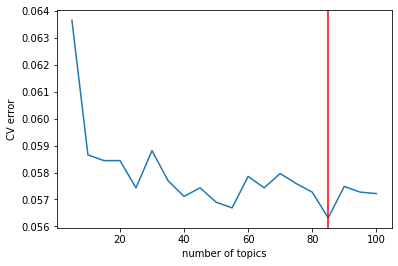

,CVaccu,CVauc,unseenaccu,unseenauc,topics,CVerror
0,0.936342,0.907810,0.936782,0.901355,5.0,0.063658
1,0.941345,0.907967,0.940826,0.899620,10.0,0.058655
2,0.941558,0.906960,0.940613,0.898091,15.0,0.058442
3,0.941558,0.905254,0.942742,0.900320,20.0,0.058442
4,0.942570,0.905804,0.940826,0.895889,25.0,0.057430
5,0.941186,0.903062,0.941252,0.895215,30.0,0.058814
6,0.942303,0.904199,0.942103,0.894801,35.0,0.057697
7,0.942889,0.904709,0.943593,0.897573,40.0,0.057111
8,0.942569,0.902249,0.942954,0.894853,45.0,0.057431
9,0.943102,0.903089,0.944444,0.900423,50.0,0.056898


In [71]:
result['topics'] = cvtopics

result['CVerror']=1-result['CVaccu']
#esult['unseenerror']=1-result['unseenaccu']

result.reset_index(drop=True, inplace=True)

#plt.plot(result['topics'],result['unseenerror'])

for i,error in enumerate(result['CVerror']):
    if error == min(result['CVerror']):
        xtick = result['topics'].iloc[i]
        
print('the optimal topics is',xtick)
plt.plot(result['topics'],result['CVerror'])        
plt.xlabel('number of topics')
plt.ylabel('CV error')
plt.axvline(x=xtick,color = 'red')
plt.show()
result